# url: https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2

# k-meansの最適なクラスター数を調べる方法

## 背景
お手軽なクラスタリング手段としてk-meansが有名であるが、以下の様な困ったポイントがある

    k-means法の問題点の一つは、クラスタの個数kを指定しなければならないことだ。クラスタリングは探索的 (exploratory) なデータ解析手法であって，分割は必ず何らかの主観や視点に基づいているということです．よって，クラスタリングした結果は，データの要約などの知見を得るために用い，客観的な証拠として用いてはなりません．

url: https://www.kamishima.net/jp/clustering/

それは知っている。で、結局クラスター数は本当に分析者の決め打ちでいいのか？
「このクラスター数はどうやって決めたの？」「これまでの分析結果からソーゴー的に考えて決定しました」とか言いたくない

## このページの目的
「最終的には分析官の判断でクラスターは決定しました」といいつつも、何かしら数値としての根拠を持ってクラスター数を決定したい

## 何か良い判断基準は無いのか？
完璧な方法ではないが、「エルボー法」と「シルエット分析」という方法で適切なクラスター数の検討ができるらしいのでその紹介をする

## Scikit-learnを使ったk-means
### ひとまずk-meansをやってみる

まずはデモデータの用意

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML # Jupyter notebook用
%matplotlib inline
# Jupyter notebook用

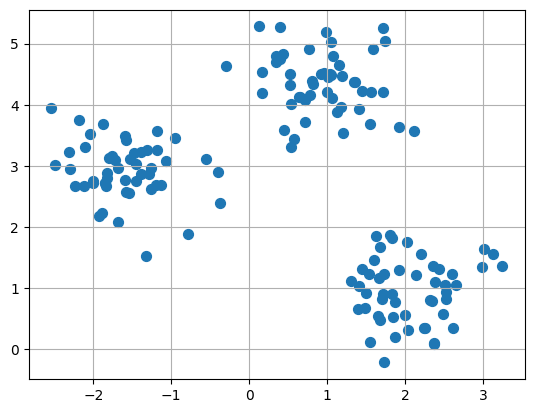

In [2]:
from sklearn.datasets import make_blobs  # ダミーデータの生成用

# Xには1つのプロットの(x,y)が、yにはそのプロットの所属するクラスター番号が入る
X,y=make_blobs(n_samples=150,         # サンプル点の総数
               n_features=2,          # 特徴量（次元数）の指定  default:2
               centers=3,             # クラスタの個数
               cluster_std=0.5,       # クラスタ内の標準偏差
               shuffle=True,          # サンプルをシャッフル
               random_state=0)        # 乱数生成器の状態を指定

plt.scatter(X[:,0],X[:,1], marker='o',s=50)
plt.grid()
plt.show()

パっと見で３つのクラスターに分かれていることがわかる
今回はこのデータを使って話を進める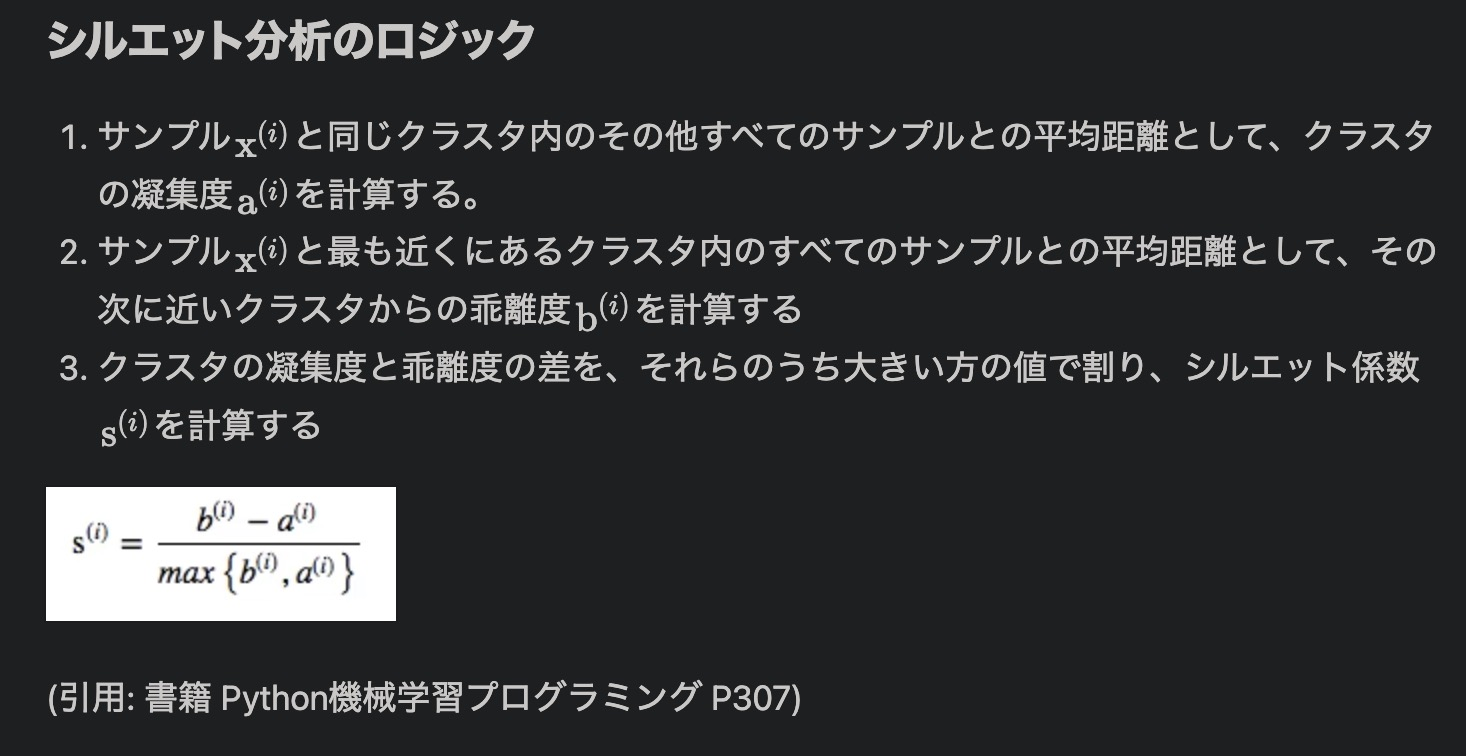

## K-meansの復習
クラスタ内誤差平方和（SSE）を反復的に最小化する

各クラスターに含まれるサンプルとそのクラスターの中心点（セントロイド）の差の2乗和を最小化する

百聞は一見にしかず: http://tech.nitoyon.com/ja/blog/2009/04/09/kmeans-visualise/

## Scikit-learnにおけるKMeansの関数
今回は k-meansを実行するのに Scikit-learnを利用した
Scikit-learnではどの機械学習モデルでも同じ関数を使う（「内容」にはk-means実行時の内容に書き換えてある）

関数	内容

    fit(X[, y])	クラスタリングの計算を実行する。
    fit_predict(X[, y])	各サンプルに対する、クラスタ番号を求める。
    fit_transform(X[, y])	クラスタリングの計算を行い、X を分析に用いた距離空間に変換して返す。
    get_params([deep])	計算に用いたパラメータを返す。
    predict(X)	X のサンプルが属しているクラスタ番号を返す
    set_params(**params)	パラメータを設定する
    transform(X[, y])	X を分析に用いた距離空間に変換して返す。

In [3]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,            # クラスターの個数
            init='random',           # セントロイドの初期値をランダムに設定  default: 'k-means++'
            n_init=10,               # 異なるセントロイドの初期値を用いたk-meansの実行回数 default: '10' 実行したうちもっとSSE値が小さいモデルを最終モデルとして選択
            max_iter=300,            # k-meansアルゴリズムの内部の最大イテレーション回数  default: '300'
            tol=1e-04,               # 収束と判定するための相対的な許容誤差 default: '1e-04'
            random_state=0)          # セントロイドの初期化に用いる乱数発生器の状態

y_km = km.fit_predict(X)

## k-means++
ランダムに設置されるセントロイドがもし互いに違い位置からスタートすると効率的にクラスタリングできない

そこでk-means++では初期のセントロイドを互いに離れた位置に配置する。それにより従来のk-means法よりも効果的なより一貫性のある結果が得られる

init = 'k-means++'にすれば良い（ただしデフォルトでk-means++になっている）分割したクラスターを色分け＆セントロイドを描写する

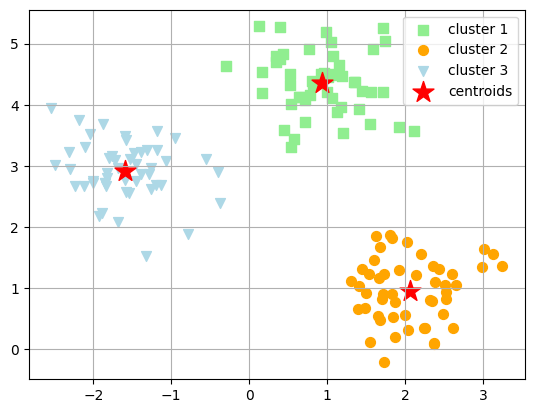

In [4]:
plt.scatter(X[y_km==0,0],         # y_km（クラスター番号）が0の時にXの0列目を抽出
                    X[y_km==0,1], # y_km（クラスター番号）が0の時にXの1列目を抽出
                    s=50,
                    c='lightgreen',
                    marker='s',
                    label='cluster 1')

plt.scatter(X[y_km==1,0],
                    X[y_km==1,1],
                    s=50,
                    c='orange',
                    marker='o',
                    label='cluster 2')

plt.scatter(X[y_km==2,0],
                   X[y_km==2,1],
                    s=50,
                    c='lightblue',
                    marker='v',
                    label='cluster 3')

plt.scatter(km.cluster_centers_[:,0],   # km.cluster_centers_には各クラスターのセントロイドの座標が入っている
                    km.cluster_centers_[:,1],
                    s=250,
                    marker='*',
                    c='red',
                    label='centroids')
plt.legend()
plt.grid()
plt.show()


## クラスタ内誤差平方和（SSE）へのアクセス
クラスタリングの性能を数値化するには、クラスタ内SSEのような指標を用いて、さまざまなk-meansクラスタリングの性能を比較する必要がある

scikit-learnではk-meansモデル適応後は inertia_属性を通じてこの値にアクセス出来る （クラスタ内SSEのことを"クラスタの慣性"cluster inertia とも呼ぶらしい ）

クラスタ内SSE値が小さいほど「歪みのない（クアスタリングがうまくいっている）良いモデル」と言える

## エルボー法
本題の「最適なクラスター数の検討を付ける方法」について

### エルボー法とは
クラスタごとのSSE値をプロットした図（それだけ）
SSE値が"ヒジ"のようにガクンと曲がった点（SSE値の低下がサチる場所）が最適なクラスター数とみなす


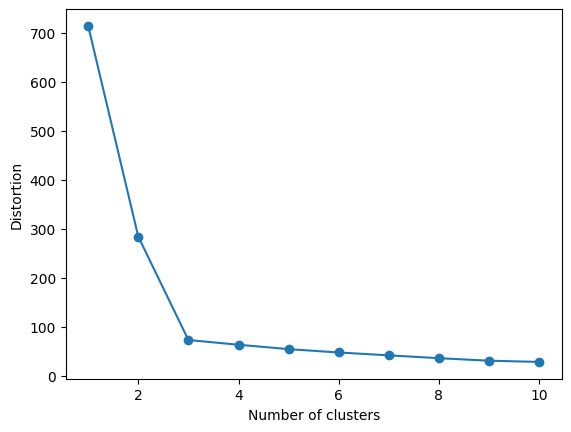

In [5]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### これがエルボー図
「ヒジが折れ曲がっているようにみえる」からそういう呼び方らしい
クラスター数3でガクッと落ちている（SSE値がサチっている）ので、「クラスター数3が最適なクラスター数」と判断できる

### ちなみに・・・
ここで具体的な図などは掲載できないが、現実のデータを使ってエルボー図を書いてみると、上記のような「綺麗なヒジ」はなかなか現れない
余程明確に分かれたクラスターデータでない限り、エルボー図は「なだらかな曲線」を描く
「エルボー図を書くと簡単に最適なクラスターの検討がつく！」ということはほぼ無い（現実はキビシイ）

## シルエット分析 Silhouette analysis
### シルエット分析とは
クラスタ内のサンプルがどの程度密にグループされているか（凝集度）の目安となるグラフを可視化（=パッと見でクラスターが上手くできているかなんとなくわかる）
１つのクラスターが隣接するクラスターとどれくらい離れているかを可視化する
また、

適切なクラスター数がどれくらいかを調べるためにも使える
シルエット分析はK-measn法以外のクラスタリングアルゴリズムにも適応できる

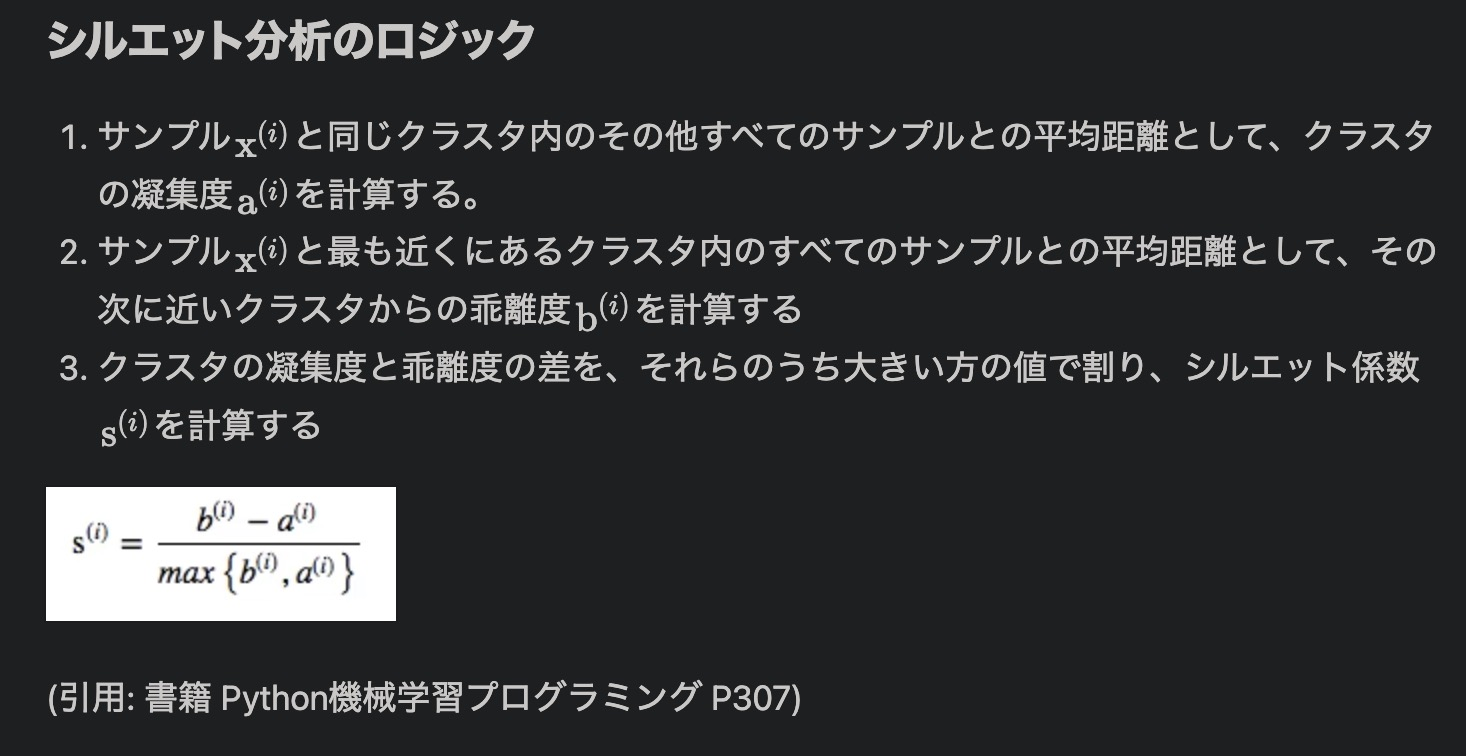

In [6]:
km = KMeans(n_clusters=3,            # クラスターの個数
            init='k-means++',        # セントロイドの初期値をランダムに設定
            n_init=10,               # 異なるセントロイドの初期値を用いたk-meansあるゴリmズムの実行回数
            max_iter=300,            # k-meansアルゴリズムの内部の最大イテレーション回数
            tol=1e-04,               # 収束と判定するための相対的な許容誤差
            random_state=0)          # セントロイドの初期化に用いる乱数発生器の状態

y_km = km.fit_predict(X)

## シルエット図を書く

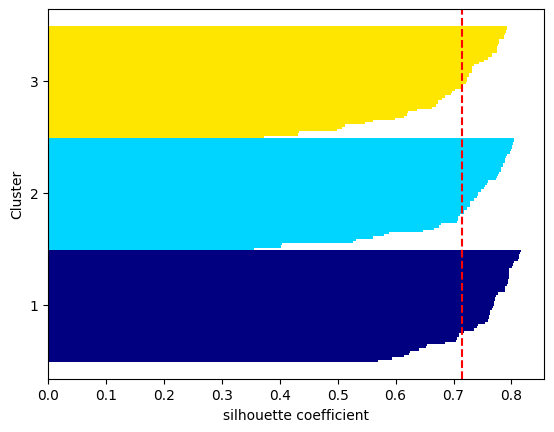

In [7]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(y_km)       # y_kmの要素の中で重複を無くす
n_clusters=cluster_labels.shape[0]     # 配列の長さを返す。つまりここでは n_clustersで指定した3となる

# シルエット係数を計算
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')  # サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]      # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
        color = cm.jet(float(i)/n_clusters)               # 色の値を作る
        plt.barh(range(y_ax_lower,y_ax_upper),            # 水平の棒グラフのを描画（底辺の範囲を指定）
                         c_silhouette_vals,               # 棒の幅（1サンプルを表す）
                         height=1.0,                      # 棒の高さ
                         edgecolor='none',                # 棒の端の色
                         color=color)                     # 棒の色
        yticks.append((y_ax_lower+y_ax_upper)/2)          # クラスタラベルの表示位置を追加
        y_ax_lower += len(c_silhouette_vals)              # 底辺の値に棒の幅を追加

silhouette_avg = np.mean(silhouette_vals)                 # シルエット係数の平均値
plt.axvline(silhouette_avg,color="red",linestyle="--")    # 係数の平均値に破線を引く
plt.yticks(yticks,cluster_labels + 1)                     # クラスタレベルを表示
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

上記のコードを見てわかるようにシルエット図はすべてのサンプルについて横向き棒グラフ（plt.barh）を書いているだけ

## シルエット図の見方
クラスターの「シルエット係数 silhouette coefficient 」が 1に近いほど、そのクラスターは他のクラスターから遠く離れていることを表す（係数は -1 ~ 1の間をとる）

    0に近いほど隣接するクラスターと接近している or 隣接するクラスターと重なっていることを表す（上手くクラスターの分離ができていない状態）
    係数がマイナス値だとクラスター化されたサンプルは間違ったクラスターに所属している可能性がある
    
シルエットの"厚さ thickness"はクラスターのサイズ（所属するサンプル数）を表す

適切にクラスター分離できていれば各クラスターのシルエットの"厚さ"は均等に近くなるらしい

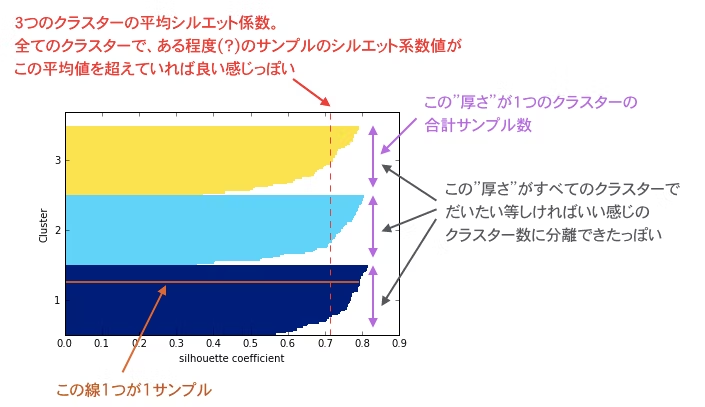

参考: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py%5D

## ダメなクラスタリングのシルエット図の例
本当はクラスターが3つに分かれているのに、2クラスターに分離させようとした場合は以下の様なシルエット図となる

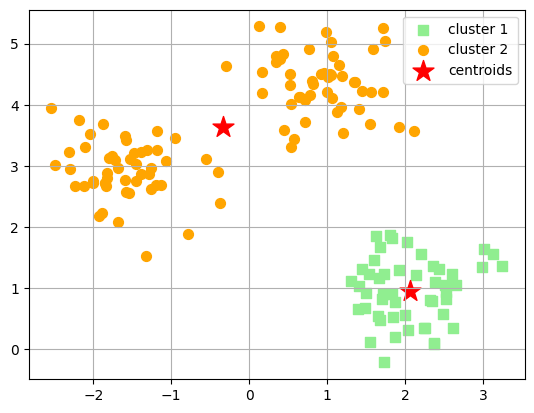

In [8]:
km = KMeans(n_clusters=2,            # クラスターの個数
            init='k-means++',        # セントロイドの初期値をランダムに設定
            n_init=10,               # 異なるセントロイドの初期値を用いたk-meansあるゴリmズムの実行回数
            max_iter=300,            # k-meansアルゴリズムの内部の最大イテレーション回数
            tol=1e-04,               # 収束と判定するための相対的な許容誤差
            random_state=0)          # セントロイドの初期化に用いる乱数発生器の状態
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0],
                   X[y_km==0,1],
                    s=50,
                    c='lightgreen',
                    marker='s',
                    label='cluster 1')

plt.scatter(X[y_km==1,0],
                   X[y_km==1,1],
                    s=50,
                    c='orange',
                    marker='o',
                    label='cluster 2')

plt.scatter(km.cluster_centers_[:,0],
                    km.cluster_centers_[:,1],
                    s=250,
                    marker='*',
                    c='red',
                    label='centroids')
plt.legend()
plt.grid()
plt.show()

本当は3クラスター存在するのに2クラスターに分けてみたダメな例。見事にセントロイドがおかしな位置にいる。

そしてそのシルエット図が以下

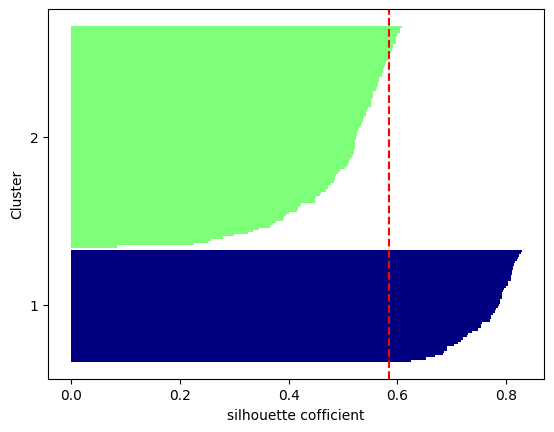

In [9]:
cluster_labels = np.unique(y_km)       # y_kmの要素の中で重複を無くす
n_clusters=cluster_labels.shape[0]     # 配列の長さを返す

# シルエット係数を計算
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)               # 色の値をセット
        plt.barh(range(y_ax_lower,y_ax_upper),            # 水平の棒グラフのを描画（底辺の範囲を指定）
                         c_silhouette_vals,               # 棒の幅
                         height=1.0,                      # 棒の高さ
                         edgecolor='none',                # 棒の端の色
                         color=color)                     # 棒の色
        yticks.append((y_ax_lower+y_ax_upper)/2)          # クラスタラベルの保油次位置を追加
        y_ax_lower += len(c_silhouette_vals)              # 底辺の値に棒の幅を追加

silhouette_avg = np.mean(silhouette_vals)                 # シルエット係数の平均値
plt.axvline(silhouette_avg,color="red",linestyle="--")    # 係数の平均値に破線を引く
plt.yticks(yticks,cluster_labels + 1)                     # クラスタレベルを表示
plt.ylabel('Cluster')
plt.xlabel('silhouette cofficient')
plt.show()

クラスター２のシルエットが厚い（=クラスター2の方にサンプルが寄りすぎている）

クラスター1,2のシルエット係数平均値（赤破線）をクラスター2のほとんどのサンプルが下回っている

「うーん、まだいまいちピンときていないのだけど...」という人は
シルエット分析を理解するためにはscikit-learn公式のページが一番わかり易い

url: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py%5D

クラスター数を変えた時にシルエット図がどのように変わるかが追いやすい

以下、scikit-learn公式のページを丸コピ

url: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py%5D

本当は4つクラスターに分かれているが、それをk-meansで2~4に分離した時のシルエット図の違いが可視化されている（4のシルエット図があるべき正しい姿で、2,3,5のシルエットは歪なシルエット、ということ）

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5662344175321901
For n_clusters = 6 The average silhouette_score is : 0.4358297989156284


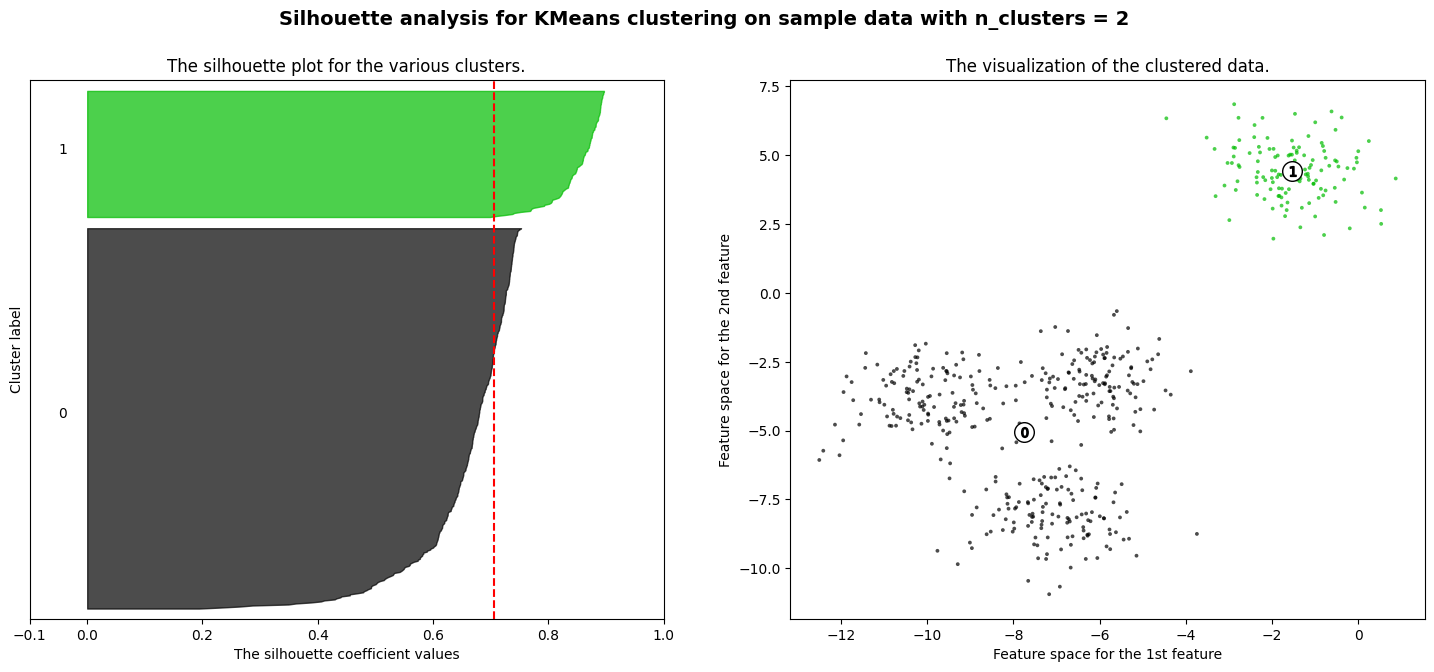

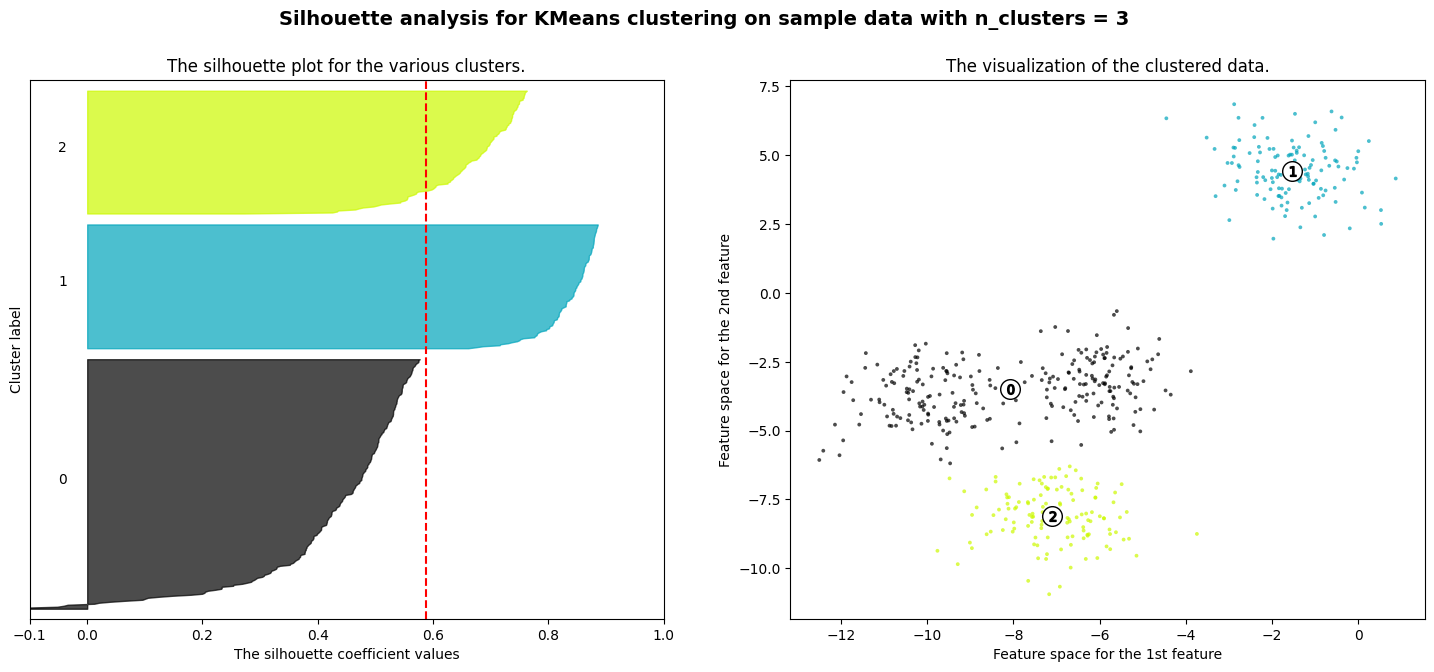

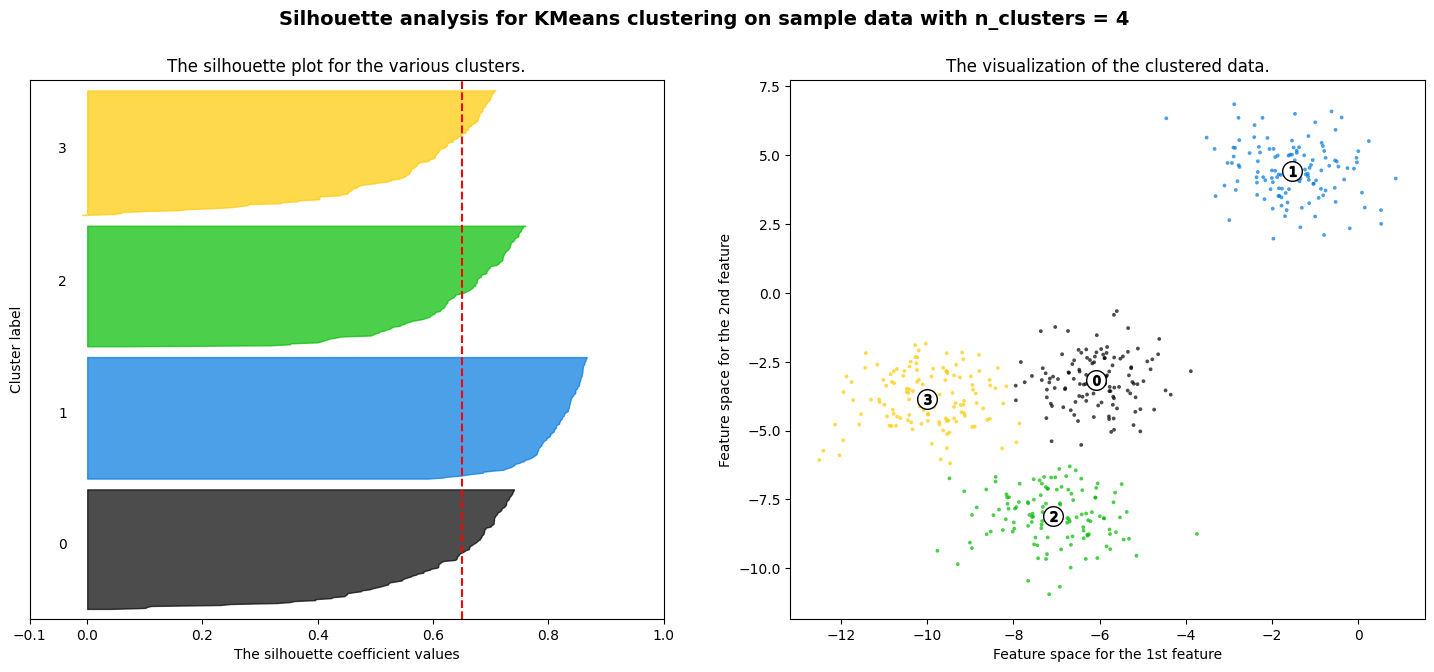

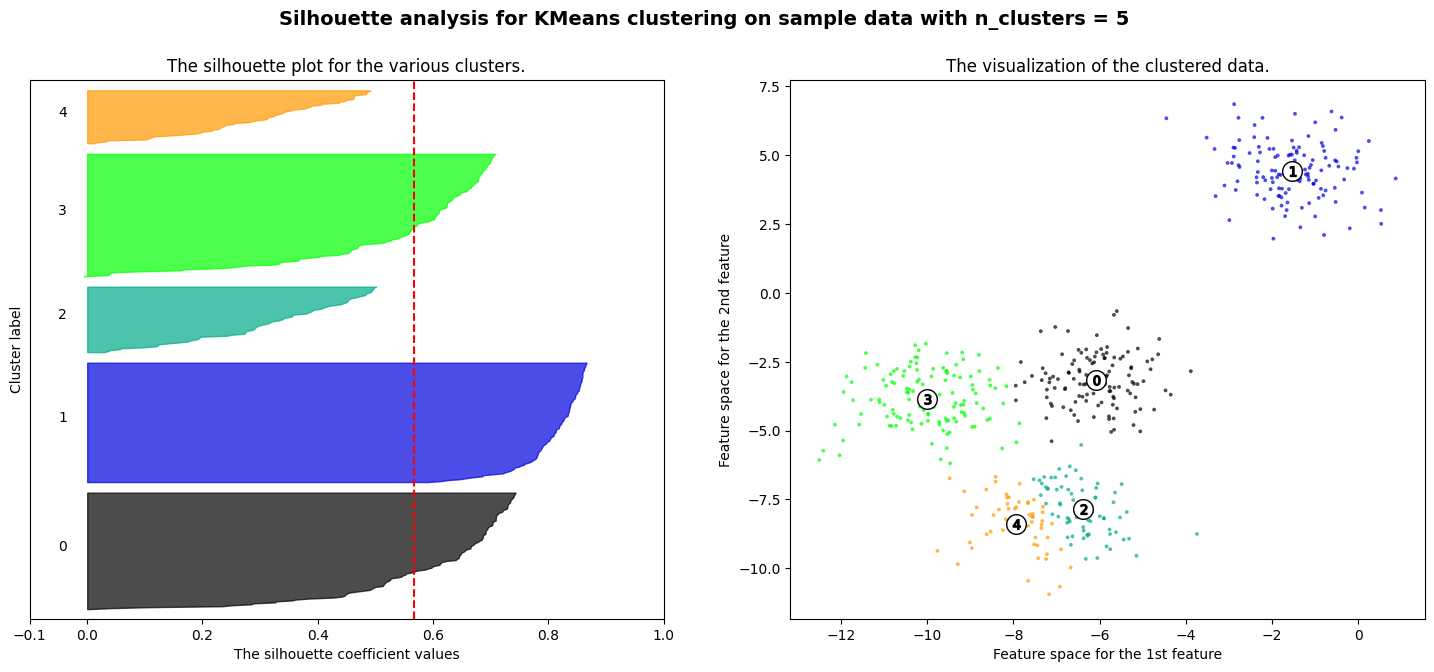

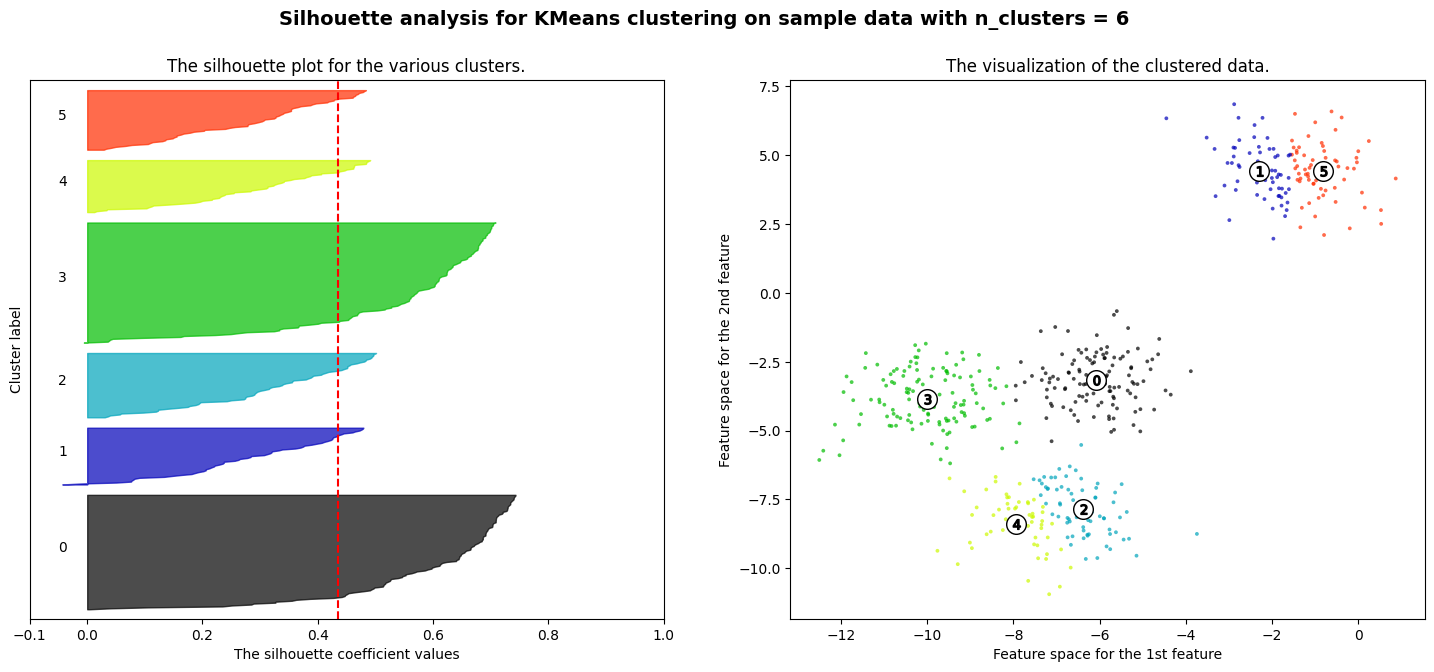

In [10]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## ちなみに・・・
言いたいことはエルボー図の時と同じだ！！！

## まとめ
クラスタリングの最適なクラスター数を見積もる時の参考となる手法として「エルボー図」と「シルエット分析」を紹介した

ただし、二つの手法とも、「これで最適なクラスター数がわかる！！！」というものではない
結局、最適なクラスター数を明確に知るお手軽な方法は無いが、「なぜこのクラスター数にしたのか」を説明するときの材料にはなる（なってほしい

## 参考
参考というか、掲載したコードはほぼ以下の写経（＋追加解説・不明瞭な箇所の補足）

書籍 Python 機械学習プログラミング （すごく良い本だと思います！少しお高いですがまじめに機械学習勉強したい人にはオススメ）
上記の本の原本著者Sebastian Raschka氏のgithubページ
Selecting the number of clusters with silhouette analysis on KMeans clustering


